In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import neuropsychology_correlations
import plots
from skrvm import RVR
from julearn import run_cross_validation
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression


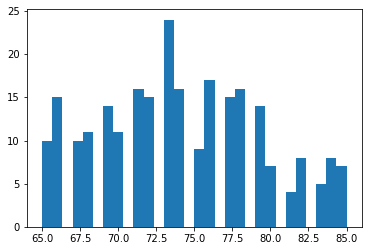

In [2]:


# %%
# LOAD DATA
# load and inspect data, set modality
# TODO: read in bootstrapping samples @antogeo
# modality = input("Which modality are you analyzing? ")
modality = 'PET'
database = "ADNI"
mode = "train"
df = pd.read_csv('../data/ADNI/test_train_' + modality + '_NP_amytau_olderthan65_42.csv')
df_train = df[df['train'] == True]
# select columns with '_' which are col's with features
col = [x for x in df_train.columns if ('_' in x)]
df_train = df_train.reset_index(drop=True)

# plot hist with Ages of train data
plt.hist(df_train['age'], bins=30)
#%%
# PREPARATION
rand_seed = 42
num_bins = 5

# define models and model names (some are already included in julearn)
rvr = RVR()

# models to test & names
models = [rvr, 'svm', 'gradientboost']
model_names = ['rvr', 'svm', 'gradientboost']
splits = 5

# hyperparameters svr & rvr
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
cs = [0.001, 0.01, 0.1, 1, 10, 100]
# hyperparameters gb
loss = ['friedman_mse', 'squared_error', 'absolute_error']
n_estimators = [10, 100, 1000]
learning_rate = [0.0001, 0.001, 0.01, 0.1]
max_depth = [2, 3, 4, 5, 6]

model_params = [{'rvr__C': cs, 'rvr__kernel': kernels},
                {'svm__C': cs, 'svm__kernel': kernels},
                {'gradientboost__n_estimators': n_estimators,
                  'gradientboost__learning_rate': learning_rate,
                  'gradientboost__max_depth': max_depth,
                  'gradientboost__random_state': [rand_seed]}]

model_results = []
scores_results = []
res = {}
res['model'] = []
res['iter'] = []
res['pred'] = []
res['ind'] = []



In [3]:

#%%
# TRAINING
# train models using 5-fold cross-validation
# TODO: read in bootstrapping samples @antogeo
for i, (model, params) in enumerate(zip(models, model_params)):
    # split data using age-bins instead of real age
    cv = StratifiedKFold(n_splits=splits).split(df_train[col],
                                                df_train['Agebins'])
    cv = list(cv)
    # run julearn function
    scores, final_model = run_cross_validation(X=col, y='age',
                                               # preprocess_X='scaler_robust',
                                               problem_type='regression',
                                               data=df_train,
                                               model=model, cv=cv,
                                               seed=rand_seed,
                                               model_params=params,
                                               return_estimator='all',
                                               scoring=['r2',
                                                'neg_mean_absolute_error'])
    model_results.append(final_model)
    scores_results.append(scores)

    # iterate over julearn results to and save results of each iteration
    for iter in range(splits):
        pred = final_model.best_estimator_.predict(df_train.iloc[cv[iter][1]][col])
        res['pred'].append(pred)
        res['iter'].append(iter)
        res['model'].append(str(model))
        res['ind'].append(cv[iter][1])

df_res = pd.DataFrame(res)
age_pred = {}
age_pred['subj'] = []
age_pred['pred'] = []
age_pred['real'] = []
age_pred['model'] = []

for i, fold in enumerate(df_res['ind']):
    for ind, sample in enumerate(fold):
        age_pred['real'].append(df_train.iloc[sample]['age'])
        age_pred['pred'].append(df_res['pred'].iloc[i][ind])
        age_pred['subj'].append(df_train.iloc[sample]['name'])
        age_pred['model'].append(df_res.iloc[i]['model'])

df_ages = pd.DataFrame(age_pred)

# assess scaling parameters for test data
scaler = RobustScaler().fit(df_train[col])


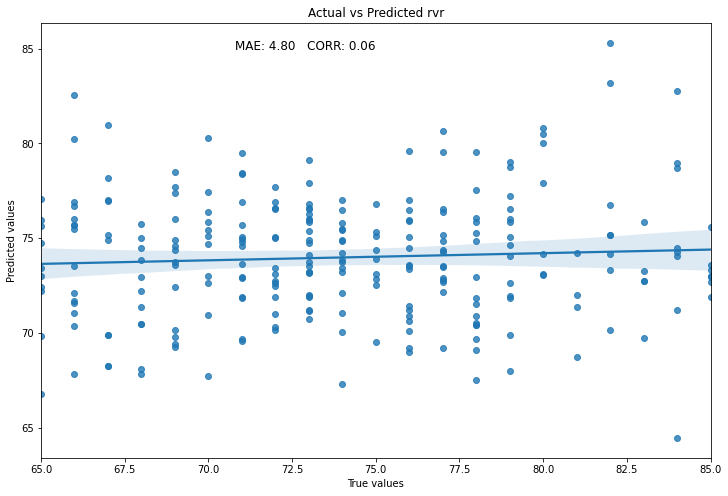

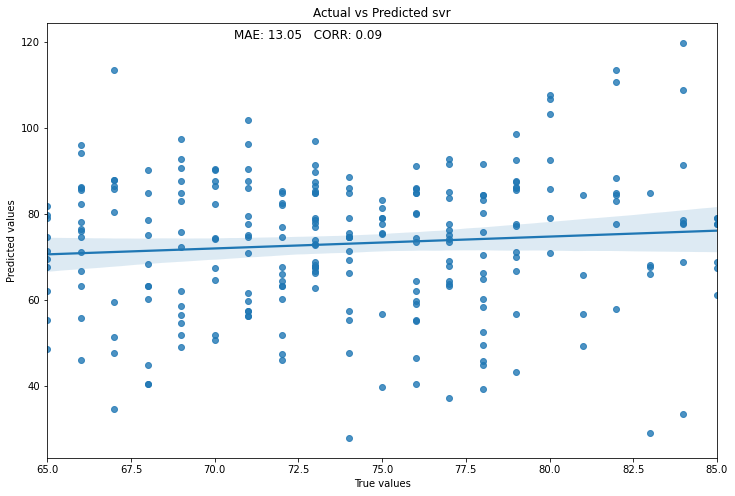

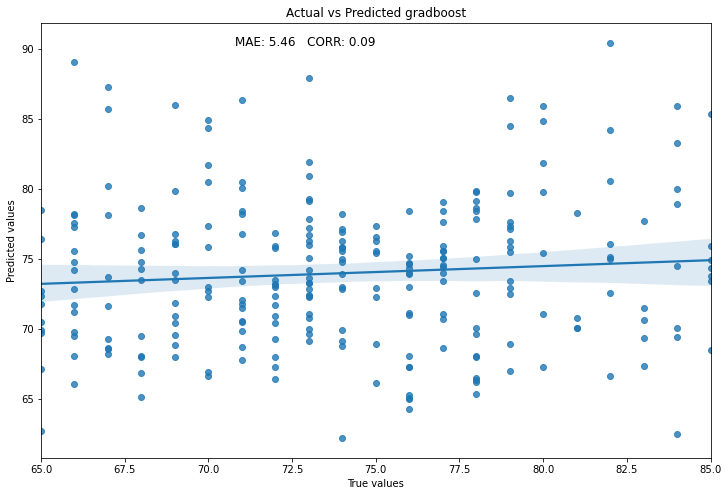

In [7]:
# %%
# BIAS CORRECTION
# Eliminate linear correlation of brain age difference and chronological age
def bias_correction(y_pred, y_true):
    lm = LinearRegression()
    lm.fit(np.array(y_pred).reshape(-1,1),
           np.array(y_true).reshape(-1,1))
    slope = lm.coef_[0][0]
    intercept = lm.intercept_[0]
    y_pred_bc = (y_pred - intercept)/slope
    
    return intercept, slope, y_pred_bc

# relevance Vectors Regression
y_true = df_train['age']
y_pred_rvr = df_ages[df_ages['model'] == 'RVR()']['pred']

intercept_rvr, slope_rvr, y_pred_rvr_bc = bias_correction(y_pred_rvr,
                                                          y_true)
plots.real_vs_pred(y_true, y_pred_rvr, "rvr", mode, 
                   modality, database)

# SVM
y_pred_svr = df_ages[df_ages['model'] == 'svm']['pred']

intercept_svr, slope_svr, y_pred_svr_bc = bias_correction(y_pred_svr,
                                                          y_true)

# plot real_vs_pred
plots.real_vs_pred(y_true, y_pred_svr_bc, "svr", mode, 
                   modality, database)

# Gradient Boost
y_pred_gb = df_ages[df_ages['model'] == 'gradientboost']['pred']


# fit a linear model for bias correction for gaussian
intercept_gb, slope_gb, y_pred_gb_bc = bias_correction(y_pred_gb,
                                                       y_true)
plots.real_vs_pred(y_true, y_pred_gb_bc, "gradboost", mode, 
                   modality, database)



In [9]:
def bias_correction(y_pred, y_true):
    lm = LinearRegression()
    lm.fit(np.array(y_pred).reshape(-1,1),
           np.array(y_true).reshape(-1,1))
    slope = lm.coef_[0][0]
    intercept = lm.intercept_[0]
    y_pred_bc = (y_pred - intercept)/slope
    
    return intercept, slope, y_pred_bc
    
# relevance Vectors Regression
y_pred_rvr = final_predictions['RVR']
y_true = df_train['age']

intercept_rvr, slope_rvr, y_pred_rvr_bc = bias_correction(y_pred_rvr,
                                                          y_true)
plots.real_vs_pred(y_true, y_pred_rvr, "rvr", mode, 
                   modality, database)

# SVM
y_pred_svr = final_predictions['SVR']

intercept_svr, slope_svr, y_pred_svr_bc = bias_correction(y_pred_svr,
                                                          y_true)
plots.real_vs_pred(y_true, y_pred_svr_bc, "svr", mode, 
                   modality, database)

# Gradient Boost
y_pred_gb = final_predictions['GradientBoostingRegressor']

intercept_gb, slope_gb, y_pred_gb_bc = bias_correction(y_pred_gb,
                                                       y_true)
plots.real_vs_pred(y_true, y_pred_gb_bc, "gradboost", mode, 
                   modality, database)

# %%
# TESTING
# How well does the model perform on unseen data?
df_test = df[df['train'] == False]
df_test = df_test.reset_index()
# apply scale parameters from training data
X_test = scaler.transform(df_test[col].values)
y_test = df_test['age'].values
mode = "test"

# plot rvr predictions against GT in test set
y_pred_rvr = final_models['RVR'].predict(X_test)
y_pred_rvr_bc = (y_pred_rvr - intercept_rvr)/slope_rvr

plots.real_vs_pred(y_test, y_pred_rvr_bc, "rvr", mode, 
                   modality, database)

# plot svr predictions against GT in test set
y_pred_svr = final_models['SVR'].predict(X_test)
y_pred_svr_bc = (y_pred_svr - intercept_svr)/slope_svr

plots.real_vs_pred(y_test, y_pred_svr_bc, "svr", mode, 
                   modality, database)


# plot gradboost predictions against GT in test set
y_pred_gb = final_models['GradientBoostingRegressor'].predict(X_test)
y_pred_gb_bc = (y_pred_gb - intercept_gb)/slope_gb

plots.real_vs_pred(y_test, y_pred_gb_bc, "gradboost", mode, 
                   modality, database)

NameError: name 'final_predictions' is not defined